In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
from sys import platform
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
if platform == "linux" or platform == "linux2":
    dir_folder = Path('/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/')
elif platform == 'win32':
    dir_folder = Path('U:\\Takashi') # put folder for windows system
vol_file = Path('depreciated/analysis_sections_based_on_swim_pattern.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')

In [3]:
from utils import *

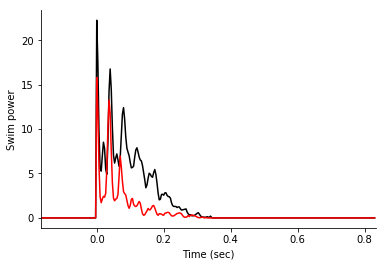

In [6]:
nfish = 1
ncell_ = 19
row = dat_xls_file.iloc[nfish]
folder = row['folder']
fish = row['fish']
# print(f'Processing {folder} {fish}')
dat_dir = dir_folder/f'{folder}/{fish}/Data/'
swim_dir = dir_folder/f'{folder}/{fish}/swim/'
dff = np.load(dat_dir/'Voltr_spikes.npz')['voltrs']
dff = dff - np.nanmedian(dff, axis=1, keepdims=True)
spk = np.load(dat_dir/'Voltr_spikes.npz')['spk']
num_cell = spk.shape[0]
# spk with padding zeros for the first 2 seconds
spk = np.r_['-1', np.zeros((num_cell, 600)), spk]
frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse.npy')

_ = np.load(f'swim_power/{folder}_{fish}_swim_dat.npz')
swim_starts = _['swim_starts']
swim_ends = _['swim_ends']
r_swim = _['r_swim']
l_swim = _['l_swim']
visu = _['visu']
task_period = _['task_period']
swim_task_index = _['swim_task_index']

p_swim = np.sqrt(r_swim**2+l_swim**2)

n_task = task_period.max().astype('int')
swim_task_index_ = (swim_task_index-1)%n_task+1
swim_bout_index_task = np.zeros(len(swim_task_index_)).astype('int')
swim_bout_index_task[0] = 1
for n_bout in range(len(swim_task_index_)-1):
    if swim_task_index_[n_bout] == swim_task_index_[n_bout-1]:
        swim_bout_index_task[n_bout] = swim_bout_index_task[n_bout-1]+1
    else:
        swim_bout_index_task[n_bout] = 1

swim_bout_index_task = swim_bout_index_task

plt.plot(np.arange(300)/300-50/300, p_swim[task_period==1, :].mean(axis=0), '-k')
plt.plot(np.arange(300)/300-50/300, p_swim[task_period==2, :].mean(axis=0), '-r')
plt.ylabel('Swim power')
plt.xlabel('Time (sec)')
plt.xlim([-50/300, 250/300])
# plt.ylim([0, 160])
# plt.vlines([0], [0], [320], colors='k', linestyles='--')
sns.despine()
plt.show()

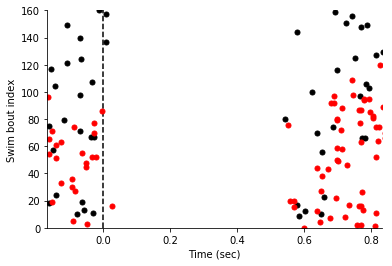

In [7]:
spk_list = np.zeros((r_swim.shape[0], 400))
for n_cell in range(spk_list.shape[0]):
    if n_cell != ncell_:
        continue
    for n, n_swim in enumerate(swim_starts):
        try:
            spk_list[n, :] = spk[n_cell, n_swim-100:n_swim+300] 
        except:
            pass
    plt_raster(spk_list[task_period==1, :], c='k')
    plt_raster(spk_list[task_period==2, :], c='r')
    # plt.title(f'Cell #{n_cell}')
    plt.ylabel('Swim bout index')
    plt.xlabel('Time (sec)')
    plt.xlim([-50/300, 250/300])
    plt.ylim([0, 160])
    plt.vlines([0], [0], [320], colors='k', linestyles='--')
    sns.despine()
    plt.show()

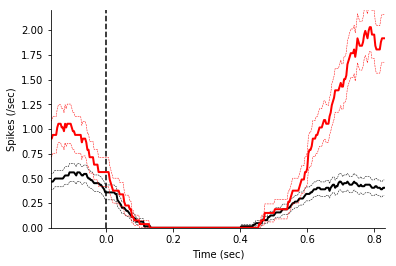

In [8]:
# k_ = gaussKernel(sigma=20)
k_ = boxcarKernel(sigma=60)
# ave_ = spk_list[task_period==1, :].mean(axis=0)*300
ave_ = []
for n_spk in spk_list[task_period==1, :]*300:
    ave_.append(smooth(n_spk, k_))
ave_ = np.array(ave_)
mean_ = ave_[:, 50:350].mean(axis=0)
std_ = ave_[:, 50:350].std(axis=0)/np.sqrt(ave_.shape[0])
plt.plot(np.arange(300)/300-50/300, mean_, '-k', lw=2)
plt.plot(np.arange(300)/300-50/300, mean_-std_, '--k', lw=0.5)
plt.plot(np.arange(300)/300-50/300, mean_+std_, '--k', lw=0.5)


ave_ = []
for n_spk in spk_list[task_period==2, :]*300:
    ave_.append(smooth(n_spk, k_))
ave_ = np.array(ave_)
mean_ = ave_[:, 50:350].mean(axis=0)
std_ = ave_[:, 50:350].std(axis=0)/np.sqrt(ave_.shape[0])
plt.plot(np.arange(300)/300-50/300, mean_, '-r', lw=2)
plt.plot(np.arange(300)/300-50/300, mean_-std_, '--r', lw=0.5)
plt.plot(np.arange(300)/300-50/300, mean_+std_, '--r', lw=0.5)

plt.ylim([0, 2.2])
plt.xlim([-50/300, 250/300])
plt.vlines([0], [0], [2.2], colors='k', linestyles='--')

plt.xlabel('Time (sec)')
plt.ylabel('Spikes (/sec)')
sns.despine()

In [17]:
from scipy.signal import medfilt

subvolt = dff.copy()
# for n, ndff in enumerate(dff):
#     subvolt[n, :] = medfilt(ndff, kernel_size=1)

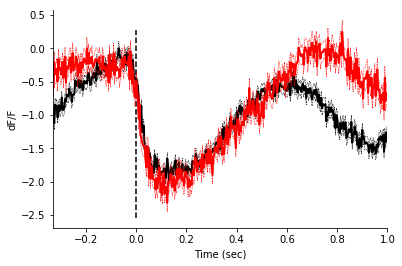

In [18]:
sub_list = np.zeros((r_swim.shape[0], 400))
for n_cell in range(spk_list.shape[0]):
    if n_cell != ncell_:
        continue
    for n, n_swim in enumerate(swim_starts):
        try:
            sub_list[n, :] = subvolt[n_cell, n_swim-100:n_swim+300] 
        except:
            pass

t_min = 0
t_max = 400
ave_ = sub_list[task_period==1, :]*100
mean_ = ave_[:, t_min:t_max].mean(axis=0)
mean_ = mean_ - mean_[:(100-t_min)].max()
max_ = mean_.max()
min_ = mean_.min()
std_ = ave_[:, t_min:t_max].std(axis=0)/np.sqrt(ave_.shape[0])
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_, '-k', lw=2)
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_-std_, '--k', lw=0.5)
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_+std_, '--k', lw=0.5)

ave_ = sub_list[task_period==2, :]*100
mean_ = ave_[:, t_min:t_max].mean(axis=0)
mean_ = mean_ - mean_[:(100-t_min)].max()
max_ = mean_.max()
min_ = mean_.min()
std_ = ave_[:, t_min:t_max].std(axis=0)/np.sqrt(ave_.shape[0])
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_, '-r', lw=2)
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_-std_, '--r', lw=0.5)
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_+std_, '--r', lw=0.5)

# plt.ylim([0, 2.2])
plt.xlim([-(100-t_min)/300, (t_max-100)/300])
plt.vlines([0], [min_-np.abs(min_)*0.1], [max_+np.abs(max_)*0.1], colors='k', linestyles='--')
plt.xlabel('Time (sec)')
plt.ylabel('dF/F')
sns.despine()

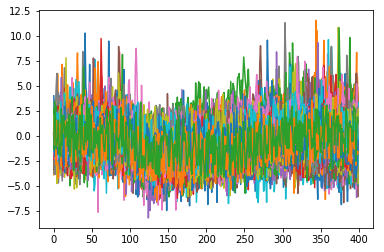

In [19]:
ave__ = ave_.copy()
ave__ = ave__ - ave__[:, :(100-t_min)].mean(axis=1, keepdims=True)
plt.plot(ave__.T)
plt.show()

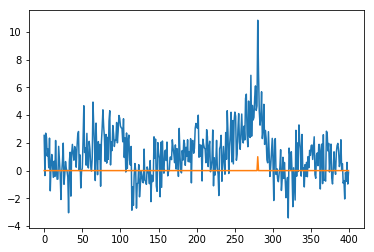

In [27]:
spk_____ = spk_list[task_period==2, :]
plt.plot(ave_[0])
plt.plot(spk_____[0])

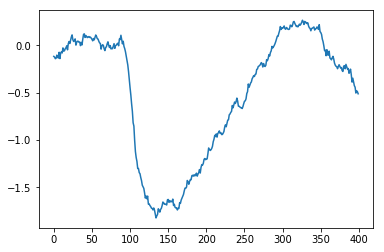